# 1 Import packages and define useful functions

In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error 
from sklearn.metrics import PredictionErrorDisplay

In [2]:
def get_shortest_array(a,b):
    '''
    input - a,b arrays (pandas.values) arrays
    output - returns length of shortest array using first index of np.shape
    '''
    
    len_a = np.shape(a)[0]
    len_b = np.shape(b)[0]
    
    return min(len_a,len_b)

In [3]:
def plot_cor(x, y, window, filename, x_name, y_name, unit='day'):
    '''
    x (df) - first time series
    y (df) - second time series
    window (int) - period length
    filename - output filename as .png
    x_name - first time series name (for title)
    y_name - second time series name (for title)
    Note that x and y don't have to be the same length. the 'get_shortest_array' function will be used to automatically trim the time series
    '''
    shortest_time_series_len = get_shortest_array(x,y)
    plt.plot(x.iloc[:shortest_time_series_len].rolling(window).corr(y.iloc[:shortest_time_series_len]).fillna(method='bfill'));
    
    # rotate x-axis labels so date labels all fit in properly
    plt.xticks(rotation=90);
    plt.title(str(window)+'-'+str(unit)+' rolling correlation between '+str(x_name)+ ' and '+str(y_name))
    plt.savefig(str(filename),dpi=600)


In [4]:
def equity_d2m(dataframe):
    '''
    for a dataframe with daily OHLC equity data, convert this to monthly OHLC data.
    '''
    
    return pd.DataFrame({"Open":dataframe.Open.resample('MS').first(),
                         "High":dataframe.High.resample('MS').max(),
                         "Low":dataframe.Low.resample('MS').min(),
                         "Price":dataframe.Price.resample('MS').last()})

In [5]:
def equity_d2q(dataframe):
    '''
    for a dataframe with daily OHLC equity data, convert this to monthly OHLC data.
    '''
    
    return pd.DataFrame({"Open":dataframe.Open.resample('QS').first(),
                         "High":dataframe.High.resample('QS').max(),
                         "Low":dataframe.Low.resample('QS').min(),
                         "Price":dataframe.Price.resample('QS').last()})

In [6]:
def conv_dt_index_to_M(dataframe):
    '''
    Helper script to ensure that all monthly time series are aligned.
    '''
    
    dataframe.index = dataframe.index.values.astype('datetime64[M]')
    return dataframe

In [7]:
def mean_abs_pct_error(y,y_pred):
    '''
    Calculate the mean absolute percentage error (MAPE) as defined in the repository of:
    https://www.relataly.com/univariate-stock-market-forecasting-using-a-recurrent-neural-network/122/
    '''
    
    return np.mean((np.abs(np.subtract(y, y_pred)/ y))) * 100

In [8]:
def macro_test_train_split(X,y):
    '''
    For macroeconomic endo/exo variables, get their length (they should be equal). Then do an approx train / test split of ratio 80/20. 
    Finally, feed this into ridge regression. 
    '''
    
    if len(X) != len(y):
        raise Exception('Endogenous and exogenous datasets should be equal in length')
    
    len_20pct = int(-1*round(len(X)*0.2))
    
    X_train = X[:len_20pct]
    y_train = y[:len_20pct]
    
    X_test = X[len_20pct:]
    y_test = y[len_20pct:]
    
    return X_train, y_train, X_test, y_test

# 2 Import data: Hang Seng and macroeconomic indicators

In [9]:
# daily time series
HK50 = pd.read_csv('data/HS/HK50.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
DXY = pd.read_csv('data/macro/daily/DXY.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HSIL = pd.read_csv('data/macro/daily/^HSIL.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
SPY = pd.read_csv('data/macro/daily/SPY.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

# currencies
AUDUSD = pd.read_csv('data/macro/daily/AUD_USD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
AUDCNY = pd.read_csv('data/macro/daily/AUD_CNY.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
CNYHKD = pd.read_csv('data/macro/daily/CNY_HKD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
USDHKD = pd.read_csv('data/macro/daily/USD_HKD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HKDEUR = pd.read_csv('data/macro/daily/HKD_EUR.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
HKDAUD = pd.read_csv('data/macro/daily/HKD_AUD.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

HK50.index = HK50.index.values.astype('datetime64[D]')
DXY.index = DXY.index.values.astype('datetime64[D]')
HSIL.index = HSIL.index.values.astype('datetime64[D]')
SPY.index = SPY.index.values.astype('datetime64[D]')
AUDUSD.index = AUDUSD.index.values.astype('datetime64[D]')
AUDCNY.index = AUDCNY.index.values.astype('datetime64[D]')
CNYHKD.index = CNYHKD.index.values.astype('datetime64[D]')
USDHKD.index = USDHKD.index.values.astype('datetime64[D]')
HKDEUR.index = HKDEUR.index.values.astype('datetime64[D]')
HKDAUD.index = HKDAUD.index.values.astype('datetime64[D]')

In [10]:
# monthly time series
US10Y = pd.read_csv('data/macro/monthly/US_10Y.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
CN10Y = pd.read_csv('data/macro/monthly/CN_10Y.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
CAIXIN = pd.read_csv('data/macro/monthly/Caixin_PMI.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

# CPI
US_CPI_FRED_all = pd.read_csv('data/macro/monthly/CPIAUCSL.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')

US_CPI_OECD = pd.read_csv('data/macro/monthly/US_CPI_OECD.csv', index_col=0, thousands=',')
US_CPI_OECD.index = pd.to_datetime(US_CPI_OECD.index, format="%b-%y")

CN_CPI_OECD = pd.read_csv('data/macro/monthly/CN_CPI_OECD.csv', index_col=0, thousands=',')
CN_CPI_OECD.index = pd.to_datetime(CN_CPI_OECD.index, format="%b-%y")

# M3 money supply
US_M2 = pd.read_csv('data/macro/monthly/US_M2.csv', index_col=0, thousands=',')
US_M2.index = pd.to_datetime(US_M2.index, format="%b-%y")

CN_M2 = pd.read_csv('data/macro/monthly/CN_M2.csv', index_col=0, thousands=',')
CN_M2.index = pd.to_datetime(CN_M2.index, format="%b-%y")

EU_M2 = pd.read_csv('data/macro/monthly/EU_M2.csv', index_col=0, thousands=',')
EU_M2.index = pd.to_datetime(EU_M2.index, format="%b-%y")


# ensure all time series are indexed properly (i.e. to the first day of the month)

US10Y = conv_dt_index_to_M(US10Y)
CN10Y = conv_dt_index_to_M(CN10Y)
CAIXIN = conv_dt_index_to_M(CAIXIN)
US_CPI_FRED_all = conv_dt_index_to_M(US_CPI_FRED_all)
US_CPI_OECD = conv_dt_index_to_M(US_CPI_OECD)
CN_CPI_OECD = conv_dt_index_to_M(CN_CPI_OECD)
US_M2 = conv_dt_index_to_M(US_M2)
CN_M2 = conv_dt_index_to_M(CN_M2)
EU_M2 = conv_dt_index_to_M(EU_M2)

In [11]:
# quarterly time series
CN_GDP = pd.read_csv('data/macro/quarterly/CN_GDP.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')
US_GDP = pd.read_csv('data/macro/quarterly/US_GDP.csv', index_col=0, parse_dates=True, infer_datetime_format=True, thousands=',')


CN_GDP.index = CN_GDP.index.to_period('Q')
CN_GDP = CN_GDP.shift()

US_GDP.index = US_GDP.index.to_period('Q')

Preprocess this data. Create a dataframe containing macroeconomic indicators. 

In [12]:
macro_daily = {"HK50": HK50,
               "DXY": DXY,
            "HSIL": HSIL,
            "SPY": SPY,
            "AUDUSD": AUDUSD,
            "AUDCNY": AUDCNY,
            "CNYHKD": CNYHKD,
            "USDHKD": USDHKD,
            "HKDEUR": HKDEUR,
            "HKDAUD": HKDAUD}

macro_daily_df = pd.DataFrame()
macro_daily_df.index = pd.date_range(start='2023-03-24',end='2000-01-03',freq='D')

for ind in macro_daily.keys():
    macro_daily_df = pd.concat([macro_daily_df, macro_daily[ind]['Price']], axis=1)
    
macro_daily_df.columns = macro_daily.keys()
macro_daily_df = macro_daily_df.dropna()

macro_daily_df = macro_daily_df[::-1]

In [13]:
macro_daily_df

,HK50,DXY,HSIL,SPY,AUDUSD,AUDCNY,CNYHKD,USDHKD,HKDEUR,HKDAUD
2023-02-03,21660.47,102.92,23.92,412.35,0.6919,4.6864,1.1579,7.8468,0.1180,0.1840
2023-02-02,21958.36,101.75,23.04,416.78,0.7076,4.7614,1.1646,7.8441,0.1168,0.1801
2023-02-01,22072.18,101.22,23.69,410.80,0.7135,4.8094,1.1630,7.8424,0.1160,0.1786
2023-01-31,21842.33,102.10,24.78,406.48,0.7054,4.7643,1.1606,7.8401,0.1174,0.1807
2023-01-30,22069.73,102.28,24.90,400.59,0.7059,4.7634,1.1606,7.8352,0.1176,0.1807
...,...,...,...,...,...,...,...,...,...,...
2013-04-02,22367.82,82.92,15.04,156.82,1.0448,6.4772,1.2522,7.7622,0.1005,0.1233
2013-03-28,22299.63,82.99,14.69,156.67,1.0412,6.4706,1.2491,7.7626,0.1005,0.1237
2013-03-27,22464.82,83.22,15.15,156.19,1.0444,6.4893,1.2494,7.7634,0.1008,0.1234
2013-03-26,22311.08,82.88,15.75,156.19,1.0484,6.5107,1.2494,7.7602,0.1003,0.1230


Reindex HK50 for monthly values, then add to macro_monthly dictionary.

In [14]:
HK50_monthly = equity_d2m(HK50)

In [15]:
macro_monthly = {"HK50": HK50_monthly['Price'],
                 "US10Y": US10Y['US Real 10yr Rate (10yr Benchmark - CPI All Items)'],
            "CN10Y": CN10Y['China Real 10yr Rate (10yr Benchmark - CPI All Items)'],
            "CAIXIN": CAIXIN['Caixin China Manufacturing PMI'],
            "US_CPI_FRED_all": US_CPI_FRED_all['CPIAUCSL'],
            "US_CPI_OECD": US_CPI_OECD['Index'],
            "CN_CPI_OECD": CN_CPI_OECD['Index'],
            "US_M2": US_M2['Index'],
            "CN_M2": CN_M2['Index'],
            "EU_M2": EU_M2['Index']}


macro_monthly_df = pd.DataFrame()
macro_monthly_df.index = pd.date_range(start='1947-01-01',end='2023-02-01',freq='MS')

for ind in macro_monthly.keys():
    macro_monthly_df = pd.concat([macro_monthly_df, macro_monthly[ind]], axis=1)
    
macro_monthly_df.columns = macro_monthly.keys()
#macro_monthly_df = macro_monthly_df.dropna()
macro_monthly_df = macro_monthly_df["03-01-2013":"12-01-2022"]
macro_monthly_df = macro_monthly_df[::-1]

In [16]:
macro_monthly_df

,HK50,US10Y,CN10Y,CAIXIN,US_CPI_FRED_all,US_CPI_OECD,CN_CPI_OECD,US_M2,CN_M2,EU_M2
2022-12-01,19781.41,NaN,NaN,49.4,298.990,125.22180,115.11560,176.06640,NaN,152.38540
2022-11-01,18597.23,-3.44,1.32,49.2,298.598,125.60740,115.22710,177.29010,NaN,152.17720
2022-10-01,14687.02,-3.66,0.55,48.1,297.987,125.73440,115.45020,177.79400,NaN,152.23390
2022-09-01,17222.83,-4.39,-0.02,49.5,296.539,125.22650,115.33870,178.52300,NaN,152.08070
2022-08-01,19954.39,-5.10,0.15,50.4,295.320,124.95770,115.00400,179.59060,NaN,151.23070
...,...,...,...,...,...,...,...,...,...,...
2013-07-01,21883.66,0.71,0.90,48.2,232.900,98.55664,96.07897,89.08839,79.37891,92.82501
2013-06-01,20803.29,0.80,0.90,49.2,232.445,98.51783,95.98406,88.70732,78.77515,92.90137
2013-05-01,22392.16,0.77,1.35,50.4,231.893,98.28198,95.98406,88.23659,78.28904,92.92949
2013-04-01,22737.01,0.56,1.10,51.6,231.797,98.10731,96.56242,87.88541,77.81362,92.68789


Reindex HK50 for quarterly values, then add to macro_quarterly dictionary.

In [17]:
HK50_quarterly = equity_d2q(HK50)
HK50_quarterly.index = HK50_quarterly.index.to_period('Q')

In [18]:
macro_quarterly = {"HK50": HK50_quarterly['Price'],
                   "CN_GDP": CN_GDP['Nominal GDP (100m Yuan)'],
            "US_GDP": US_GDP['GDP']}


macro_quarterly_df = pd.DataFrame()
#macro_quarterly_df.index = pd.date_range(start='1947Q1',end='2023Q1',freq='Q')

for ind in macro_quarterly.keys():
    macro_quarterly_df = pd.concat([macro_quarterly_df, macro_quarterly[ind]], axis=1)
    
macro_quarterly_df.columns = macro_quarterly.keys()
macro_quarterly_df = macro_quarterly_df.dropna()
macro_quarterly_df = macro_quarterly_df[::-1]

In [19]:
macro_quarterly_df

,HK50,CN_GDP,US_GDP
2022Q4,19781.41,335507.9,26144.956
2022Q3,17222.83,309270.6,25723.941
2022Q2,21859.79,293919.5,25248.476
2022Q1,21996.85,271509.2,24740.480
2021Q4,23397.67,325899.4,24349.121
...,...,...,...
2001Q4,11397.21,31716.8,10660.465
2001Q3,9950.70,28333.3,10598.020
2001Q2,13042.53,26726.6,10599.000
2001Q1,12760.64,24086.4,10470.231


## 2.1 Calculate returns dataframes

In [20]:
list_of_returns = list(macro_daily_df.columns)
list_of_returns.remove('HSIL')

for elem in list_of_returns:
    macro_daily_df[elem] = np.log(macro_daily_df[elem].dropna()) - np.log(macro_daily_df[elem].dropna().shift(-1))
    
macro_daily_df.rename(columns={'DXY': 'DXY ret.',
                               'HK50': 'HK50 ret.',
                               'SPY': 'SPY ret.', 
                               'AUDUSD': 'AUDUSD ret.',
                               'AUDCNY': 'AUDCNY ret.',
                               'CNYHKD': 'CNYHKD ret.',
                               'USDHKD': 'USDHKD ret.',
                               'HKDEUR': 'HKDEUR ret.',
                               'HKDAUD': 'HKDAUD ret.'}, inplace=True)

In [21]:
macro_daily_df

,HK50 ret.,DXY ret.,HSIL,SPY ret.,AUDUSD ret.,AUDCNY ret.,CNYHKD ret.,USDHKD ret.,HKDEUR ret.,HKDAUD ret.
2023-02-03,-0.013659,0.011433,23.92,-0.010686,-0.022438,-0.015877,-0.005770,0.000344,0.010222,0.021424
2023-02-02,-0.005170,0.005222,23.04,0.014452,-0.008303,-0.010031,0.001375,0.000217,0.006873,0.008364
2023-02-01,0.010468,-0.008656,23.69,0.010572,0.011417,0.009422,0.002066,0.000293,-0.011997,-0.011690
2023-01-31,-0.010357,-0.001761,24.78,0.014596,-0.000709,0.000189,0.000000,0.000625,-0.001702,0.000000
2023-01-30,-0.027669,0.003428,24.90,-0.012626,-0.006214,-0.011314,0.006050,0.000766,0.000851,0.004993
...,...,...,...,...,...,...,...,...,...,...
2013-04-02,0.003053,-0.000844,15.04,0.000957,0.003452,0.001019,0.002479,-0.000052,0.000000,-0.003239
2013-03-28,-0.007380,-0.002768,14.69,0.003068,-0.003069,-0.002886,-0.000240,-0.000103,-0.002981,0.002428
2013-03-27,0.006867,0.004094,15.15,0.000000,-0.003823,-0.003292,0.000000,0.000412,0.004973,0.003247
2013-03-26,0.002690,0.000603,15.75,0.007971,0.001623,0.001814,-0.000240,-0.000206,0.000998,-0.001625


In [22]:
list_of_returns = list(macro_monthly_df.columns)
list_of_returns.remove('US10Y')
list_of_returns.remove('CN10Y')
list_of_returns.remove('CAIXIN')

for elem in list_of_returns:
    macro_monthly_df[elem] = np.log(macro_monthly_df[elem].dropna()) - np.log(macro_monthly_df[elem].dropna().shift(-1))
    
macro_monthly_df.rename(columns={'US_CPI_FRED_all': 'US_CPI_FRED_all ret.',
                                 'HK50': 'HK50 ret.',
                                 'US_CPI_OECD': 'US_CPI_OECD ret.',
                                 'CN_CPI_OECD': 'CN_CPI_OECD ret.',
                                 'US_M2': 'US_M2 ret.',
                                 'CN_M2': 'CN_M2 ret.',
                                 'EU_M2': 'EU_M2 ret.'}, inplace=True)

In [23]:
macro_monthly_df

,HK50 ret.,US10Y,CN10Y,CAIXIN,US_CPI_FRED_all ret.,US_CPI_OECD ret.,CN_CPI_OECD ret.,US_M2 ret.,CN_M2 ret.,EU_M2 ret.
2022-12-01,0.061730,NaN,NaN,49.4,0.001312,-0.003075,-0.000968,-0.006926,NaN,0.001367
2022-11-01,0.236049,-3.44,1.32,49.2,0.002048,-0.001011,-0.001934,-0.002838,NaN,-0.000373
2022-10-01,-0.159272,-3.66,0.55,48.1,0.004871,0.004048,0.000966,-0.004092,NaN,0.001007
2022-09-01,-0.147213,-4.39,-0.02,49.5,0.004119,0.002149,0.002906,-0.005962,NaN,0.005605
2022-08-01,-0.010078,-5.10,0.15,50.4,0.002346,-0.000354,-0.000970,-0.000194,NaN,0.006278
...,...,...,...,...,...,...,...,...,...,...
2013-07-01,0.050629,0.71,0.90,48.2,0.001956,0.000394,0.000988,0.004287,0.007635,-0.000822
2013-06-01,-0.073600,0.80,0.90,49.2,0.002378,0.002397,0.000000,0.005321,0.006190,-0.000303
2013-05-01,-0.015283,0.77,1.35,50.4,0.000414,0.001779,-0.006008,0.003988,0.006091,0.002603
2013-04-01,0.019424,0.56,1.10,51.6,-0.002090,-0.001040,0.001975,0.003397,0.012951,0.005008


In [24]:
list_of_returns = list(macro_quarterly_df.columns)

for elem in list_of_returns:
    macro_quarterly_df[elem] = np.log(macro_quarterly_df[elem].dropna()) - np.log(macro_quarterly_df[elem].dropna().shift(-1))
    
macro_quarterly_df.rename(columns={'CN_GDP': 'CN_GDP ret.',
                                   'HK50': 'HK50 ret.',
                                 'US_GDP': 'US_GDP ret.'}, inplace=True)

In [25]:
macro_quarterly_df

,HK50 ret.,CN_GDP ret.,US_GDP ret.
2022Q4,0.138507,0.081429,0.016234
2022Q3,-0.238413,0.050911,0.018656
2022Q2,-0.006250,0.079310,0.020325
2022Q1,-0.061737,-0.182593,0.015945
2021Q4,-0.049119,0.112276,0.033352
...,...,...,...
2001Q4,0.135726,0.112809,0.005875
2001Q3,-0.270573,0.058378,-0.000092
2001Q2,0.021850,0.104012,0.012224
2001Q1,-0.168033,-0.192326,0.003299


# 3 Descriptive statistics

## 3.1 Daily indicators

In [24]:
for elem in macro_daily_df.keys():
    mean = str(round(macro_daily_df[elem].mean()*100.,5))+'%'
    sdev = str(round(macro_daily_df[elem].std()*100.,5))+'%'
    count = macro_daily_df[elem].size
    print("The mean, standard dev and count of "+str(elem)+" are: "+str(mean)+' '+str(sdev)+' '+str(count))

The mean, standard dev and count of HK50 ret. are: -0.00113% 1.29038% 2372
The mean, standard dev and count of DXY ret. are: 0.00916% 0.44546% 2372
The mean, standard dev and count of HSIL are: 2050.9296% 609.21473% 2372
The mean, standard dev and count of SPY ret. are: 0.04128% 1.13149% 2372
The mean, standard dev and count of AUDUSD ret. are: -0.01746% 0.66382% 2372
The mean, standard dev and count of AUDCNY ret. are: -0.01379% 0.62466% 2372
The mean, standard dev and count of CNYHKD ret. are: -0.00322% 0.23994% 2372
The mean, standard dev and count of USDHKD ret. are: 0.00046% 0.03789% 2372
The mean, standard dev and count of HKDEUR ret. are: 0.0069% 0.51315% 2372
The mean, standard dev and count of HKDAUD ret. are: 0.01692% 0.66058% 2372


## 3.2 Monthly indicators

In [25]:
for elem in macro_monthly_df.keys():
    mean = str(round(macro_monthly_df[elem].mean()*100.,5))+'%'
    sdev = str(round(macro_monthly_df[elem].std()*100.,5))+'%'
    count = macro_monthly_df[elem].size
    print("The mean, standard dev and count of "+str(elem)+" are: "+str(mean)+' '+str(sdev)+' '+str(count))

The mean, standard dev and count of HK50 ret. are: -0.10242% 5.65415% 118
The mean, standard dev and count of US10Y are: -32.89744% 217.65741% 118
The mean, standard dev and count of CN10Y are: 134.87179% 106.13252% 118
The mean, standard dev and count of CAIXIN are: 5015.76271% 168.3373% 118
The mean, standard dev and count of US_CPI_FRED_all ret. are: 0.21578% 0.28959% 118
The mean, standard dev and count of US_CPI_OECD ret. are: 0.20768% 0.35999% 118
The mean, standard dev and count of CN_CPI_OECD ret. are: 0.1519% 0.50879% 118
The mean, standard dev and count of US_M2 ret. are: 0.59677% 0.79895% 118
The mean, standard dev and count of CN_M2 ret. are: 0.86035% 0.2949% 118
The mean, standard dev and count of EU_M2 ret. are: 0.42922% 0.3361% 118


## 3.3 Quarterly indicators

In [27]:
for elem in macro_quarterly_df.keys():
    mean = str(round(macro_quarterly_df[elem].mean()*100.,5))+'%'
    sdev = str(round(macro_quarterly_df[elem].std()*100.,5))+'%'
    count = macro_quarterly_df[elem].size
    print("The mean, standard dev and count of "+str(elem)+" are: "+str(mean)+' '+str(sdev)+' '+str(count))

The mean, standard dev and count of HK50 ret. are: 0.30721% 10.67568% 89
The mean, standard dev and count of CN_GDP ret. are: 2.77463% 11.62301% 89
The mean, standard dev and count of US_GDP ret. are: 1.04366% 1.56603% 89


# 4 Correlation

## 4.1 Daily indicators

In [41]:
list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

for elem in list_of_exo:
    filename = "HK50_"+str(elem)+"_20corr_daily.png"
    x_name = "HK50"
    y_name = str(elem)
    plot_cor(macro_daily_df['HK50 ret.'], macro_daily_df[elem], 20, filename, x_name, y_name, unit='day')
    plt.close()

## 4.2 Monthly indicators

In [ ]:
list_of_exo = list(macro_monthly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

for elem in list_of_exo:
    filename = "HK50_"+str(elem)+"_12corr_monthly.png"
    x_name = "HK50"
    y_name = str(elem)
    plot_cor(macro_monthly_df['HK50 ret.'], macro_monthly_df[elem], 12, filename, x_name, y_name, unit='month')
    plt.close()

# 5 OLS regression

## 5.1 Daily models

In [28]:
macro_daily_df['2013-03-25':'2023-02-02']

,HK50 ret.,DXY ret.,HSIL,SPY ret.,AUDUSD ret.,AUDCNY ret.,CNYHKD ret.,USDHKD ret.,HKDEUR ret.,HKDAUD ret.
2023-02-02,-0.005170,0.005222,23.04,0.014452,-0.008303,-0.010031,0.001375,0.000217,0.006873,0.008364
2023-02-01,0.010468,-0.008656,23.69,0.010572,0.011417,0.009422,0.002066,0.000293,-0.011997,-0.011690
2023-01-31,-0.010357,-0.001761,24.78,0.014596,-0.000709,0.000189,0.000000,0.000625,-0.001702,0.000000
2023-01-30,-0.027669,0.003428,24.90,-0.012626,-0.006214,-0.011314,0.006050,0.000766,0.000851,0.004993
2023-01-27,0.005397,0.000883,22.45,0.002295,-0.001547,-0.001556,0.000087,0.000153,0.001704,0.001670
...,...,...,...,...,...,...,...,...,...,...
2013-04-02,0.003053,-0.000844,15.04,0.000957,0.003452,0.001019,0.002479,-0.000052,0.000000,-0.003239
2013-03-28,-0.007380,-0.002768,14.69,0.003068,-0.003069,-0.002886,-0.000240,-0.000103,-0.002981,0.002428
2013-03-27,0.006867,0.004094,15.15,0.000000,-0.003823,-0.003292,0.000000,0.000412,0.004973,0.003247
2013-03-26,0.002690,0.000603,15.75,0.007971,0.001623,0.001814,-0.000240,-0.000206,0.000998,-0.001625


In [29]:
# new method using dropna to avoid look-ahead bias
list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_coinc = {}

for elem in list_of_exo:
    X = macro_daily_df[elem]['2013-03-25':'2023-02-02'].dropna()
    y = macro_daily_df['HK50 ret.']['2013-03-25':'2023-02-02'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_coinc[elem] = sm.OLS(y, X).fit() 

### 5.1.1 Indicators are assumed to lead the HSI

In [30]:
# leading indicator variables and date ranges
#macro_daily_df.shift(5)['2013-03-26':'2023-02-03'].dropna() # 5 days. Dates ["2013-03-26":"2023-01-27"]
#macro_daily_df.shift(20)['2013-03-26':'2023-02-03'].dropna() # 20 days. Dates ["2013-03-26":"2023-12-30"]
#macro_daily_df.shift(60)['2013-03-26':'2023-02-03'].dropna() # 60 days. Dates ["2013-03-26":"2022-11-01"]

In [31]:
# indicators lead the HSI by 5 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X5R = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(5)["2013-03-26":"2023-01-27"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-03-26":"2023-01-27"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X5R[elem] = sm.OLS(y, X).fit() 

In [32]:
# indicators lead the HSI by 20 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X20R = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(20)["2013-03-26":"2023-12-30"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-03-26":"2023-12-30"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X20R[elem] = sm.OLS(y, X).fit() 

In [33]:
# indicators lead the HSI by 60 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X60R = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(60)["2013-03-26":"2022-11-01"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-03-26":"2022-11-01"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X60R[elem] = sm.OLS(y, X).fit() 

### 5.1.2 Indicators are assumed to lag the HSI

In [34]:
# lagging indicator variables and date ranges
#macro_daily_df.shift(-5)['2013-03-25':'2023-02-02'].dropna() # 5 days. Dates ["2013-04-05":"2023-02-02"]
#macro_daily_df.shift(-20)['2013-03-25':'2023-02-02'].dropna() # 20 days. Dates ["2013-04-26":"2023-02-02"]
#macro_daily_df.shift(-60)['2013-03-25':'2023-02-02'].dropna() # 60 days. Dates ["2013-06-27":"2023-02-02"]

In [35]:
# indicators lags the HSI by 5 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X5L = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(-5)["2013-04-05":"2023-02-02"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-04-05":"2023-02-02"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X5L[elem] = sm.OLS(y, X).fit() 

In [36]:
# indicators lags the HSI by 20 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X20L = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(-20)["2013-04-26":"2023-02-02"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-04-26":"2023-02-02"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X20L[elem] = sm.OLS(y, X).fit() 

In [37]:
# indicators lags the HSI by 60 days. 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

daily_models_OLS_X60L = {}

for elem in list_of_exo:
    X = macro_daily_df[elem].shift(-60)["2013-06-27":"2023-02-02"].dropna()
    y = macro_daily_df['HK50 ret.']["2013-06-27":"2023-02-02"].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    daily_models_OLS_X60L[elem] = sm.OLS(y, X).fit() 

## 5.2 Monthly models

In [38]:
# leave out 'CN_M2 ret.; dataset only goes up to 2018.
macro_monthly_df[['HK50 ret.', 'US10Y', 'CN10Y', 'CAIXIN', 'US_CPI_FRED_all ret.',
       'US_CPI_OECD ret.', 'CN_CPI_OECD ret.', 'US_M2 ret.', 
       'EU_M2 ret.']].dropna()

,HK50 ret.,US10Y,CN10Y,CAIXIN,US_CPI_FRED_all ret.,US_CPI_OECD ret.,CN_CPI_OECD ret.,US_M2 ret.,EU_M2 ret.
2022-11-01,0.236049,-3.44,1.32,49.2,0.002048,-0.001011,-0.001934,-0.002838,-0.000373
2022-10-01,-0.159272,-3.66,0.55,48.1,0.004871,0.004048,0.000966,-0.004092,0.001007
2022-09-01,-0.147213,-4.39,-0.02,49.5,0.004119,0.002149,0.002906,-0.005962,0.005605
2022-08-01,-0.010078,-5.10,0.15,50.4,0.002346,-0.000354,-0.000970,-0.000194,0.006278
2022-07-01,-0.081122,-5.81,0.06,51.7,-0.000339,-0.000118,0.004857,0.001332,0.006438
...,...,...,...,...,...,...,...,...,...
2013-08-01,-0.006983,1.24,1.45,47.7,0.002384,0.001202,0.005018,0.005520,0.001804
2013-07-01,0.050629,0.71,0.90,48.2,0.001956,0.000394,0.000988,0.004287,-0.000822
2013-06-01,-0.073600,0.80,0.90,49.2,0.002378,0.002397,0.000000,0.005321,-0.000303
2013-05-01,-0.015283,0.77,1.35,50.4,0.000414,0.001779,-0.006008,0.003988,0.002603


In [39]:
macro_monthly_df_short = macro_monthly_df[['HK50 ret.', 'US10Y', 'CN10Y', 'CAIXIN', 'US_CPI_FRED_all ret.',
       'US_CPI_OECD ret.', 'CN_CPI_OECD ret.', 'US_M2 ret.', 
       'EU_M2 ret.']].dropna()

In [40]:
# new method using dropna to avoid look-ahead bias
list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_coinc = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem]['2013-04-01':'2022-11-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-04-01':'2022-11-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_coinc[elem] = sm.OLS(y, X).fit() 

### 5.2.1 Indicators are assumed to lead the HSI

In [41]:
# leading indicator variables and date ranges
#macro_monthly_df_short.shift(1)['2013-04-01':'2022-11-01'].dropna() # 5 days. Dates ['2013-04-01':'2022-10-01']
#macro_monthly_df_short.shift(3)['2013-04-01':'2022-11-01'].dropna() # 20 days. Dates ['2013-04-01':'2022-08-01']
#macro_monthly_df_short.shift(6)['2013-04-01':'2022-11-01'].dropna() # 60 days. Dates ['2013-04-01':'2022-05-01']

In [42]:
# indicators lead the HSI by 1 month. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X1R = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(1)['2013-04-01':'2022-10-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-04-01':'2022-10-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X1R[elem] = sm.OLS(y, X).fit() 

In [43]:
# indicators lead the HSI by 3 months. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X3R = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(3)['2013-04-01':'2022-08-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-04-01':'2022-08-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X3R[elem] = sm.OLS(y, X).fit() 

In [44]:
# indicators lead the HSI by 6 months. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X6R = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(6)['2013-04-01':'2022-05-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-04-01':'2022-05-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X6R[elem] = sm.OLS(y, X).fit() 

### 5.2.2 Indicators are assumed to lag the HSI

In [45]:
# lagging indicator variables and date ranges
#macro_monthly_df_short.shift(-1)['2013-04-01':'2022-11-01'].dropna() # 1 month. Dates ['2013-05-01':'2022-11-01']
#macro_monthly_df_short.shift(-3)['2013-04-01':'2022-11-01'].dropna() # 3 months. Dates ['2013-07-01':'2022-11-01']
#macro_monthly_df_short.shift(-6)['2013-04-01':'2022-11-01'].dropna() # 6 months. Dates ['2013-10-01':'2022-11-01']

In [46]:
# indicators lag the HSI by 1 month. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X1L = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(-1)['2013-05-01':'2022-11-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-05-01':'2022-11-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X1L[elem] = sm.OLS(y, X).fit() 

In [47]:
# indicators lag the HSI by 3 months. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X3L = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(-3)['2013-07-01':'2022-11-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-07-01':'2022-11-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X3L[elem] = sm.OLS(y, X).fit() 

In [48]:
# indicators lag the HSI by 6 months. 

list_of_exo = list(macro_monthly_df_short.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

monthly_models_OLS_X6L = {}

for elem in list_of_exo:
    X = macro_monthly_df_short[elem].shift(-6)['2013-10-01':'2022-11-01'].dropna()
    y = macro_monthly_df_short['HK50 ret.']['2013-10-01':'2022-11-01'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    monthly_models_OLS_X6L[elem] = sm.OLS(y, X).fit() 

## 5.3 Quarterly models

In [93]:
# new method using dropna to avoid look-ahead bias
list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_coinc = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].dropna()
    y = macro_quarterly_df['HK50 ret.'].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_coinc[elem] = sm.OLS(y, X).fit() 

### 5.3.1 Indicators are assumed to lead the HSI

In [97]:
# indicators lead the HSI by 1 quarter. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X1R = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(1).iloc[2:].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[1:].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X1R[elem] = sm.OLS(y, X, missing='drop').fit() 

In [98]:
# indicators lead the HSI by 2 quarter. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X2R = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(2).iloc[2:].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[2:].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X2R[elem] = sm.OLS(y, X, missing='drop').fit() 

In [99]:
# indicators lead the HSI by 4 quarter. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X4R = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(4).iloc[4:].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[4:].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X4R[elem] = sm.OLS(y, X, missing='drop').fit() 

### 5.3.2 Indicators are assumed to lags the HSI

In [100]:
# indicators lags the HSI by 1 quarter. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X1L = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(-1).iloc[:-2].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[:-2].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X1L[elem] = sm.OLS(y, X).fit() 

In [101]:
# indicators lags the HSI by 2 quarters. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X2L = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(-2).iloc[:-3].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[:-3].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X2L[elem] = sm.OLS(y, X).fit() 

In [102]:
# indicators lags the HSI by 4 quarters. 

list_of_exo = list(macro_quarterly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

quarterly_models_OLS_X4L = {}

for elem in list_of_exo:
    X = macro_quarterly_df[elem].shift(-4).iloc[:-5].dropna()
    y = macro_quarterly_df['HK50 ret.'].iloc[:-5].dropna()
    y = y.reindex(X.index)
    
    X = sm.add_constant(X)
    X = StandardScaler().fit_transform(X)
    quarterly_models_OLS_X4L[elem] = sm.OLS(y, X).fit() 

# 6 OLS regression results

In [103]:
for elem in daily_models_OLS_coinc.keys():
    print('Exo variable: '+str(elem)+'. AIC: '+str(daily_models_OLS_coinc[elem].aic))    

Exo variable: DXY ret.. AIC: -13901.292999041889
Exo variable: HSIL. AIC: nan
Exo variable: SPY ret.. AIC: -14023.763804565107
Exo variable: AUDUSD ret.. AIC: -14038.873080877987
Exo variable: AUDCNY ret.. AIC: -13953.615816410176
Exo variable: CNYHKD ret.. AIC: -14018.601417065911
Exo variable: USDHKD ret.. AIC: -13996.312147841098
Exo variable: HKDEUR ret.. AIC: -13895.15830372911
Exo variable: HKDAUD ret.. AIC: -14024.208682084183


In [104]:
for elem in daily_models_OLS_X5R.keys():
    print('Exo variable (index leads +5): '+str(elem)+'. AIC: '+str(daily_models_OLS_X5R[elem].aic))    

Exo variable (index leads +5): DXY ret.. AIC: -13875.85061129116
Exo variable (index leads +5): HSIL. AIC: -13893.260351055585
Exo variable (index leads +5): SPY ret.. AIC: -13874.23897175151
Exo variable (index leads +5): AUDUSD ret.. AIC: -13875.994084554182
Exo variable (index leads +5): AUDCNY ret.. AIC: -13876.5169644413
Exo variable (index leads +5): CNYHKD ret.. AIC: -13872.10681976689
Exo variable (index leads +5): USDHKD ret.. AIC: -13872.0995069368
Exo variable (index leads +5): HKDEUR ret.. AIC: -13874.689401782049
Exo variable (index leads +5): HKDAUD ret.. AIC: -13876.28123080331


In [105]:
for elem in daily_models_OLS_X20R.keys():
    print('Exo variable (index leads +20): '+str(elem)+'. AIC: '+str(daily_models_OLS_X20R[elem].aic))    

Exo variable (index leads +20): DXY ret.. AIC: -13787.068533014415
Exo variable (index leads +20): HSIL. AIC: -13798.185839018268
Exo variable (index leads +20): SPY ret.. AIC: -13788.427750321694
Exo variable (index leads +20): AUDUSD ret.. AIC: -13789.563468587563
Exo variable (index leads +20): AUDCNY ret.. AIC: -13794.528739447338
Exo variable (index leads +20): CNYHKD ret.. AIC: -13795.685090244977
Exo variable (index leads +20): USDHKD ret.. AIC: -13787.783270970303
Exo variable (index leads +20): HKDEUR ret.. AIC: -13787.031860597464
Exo variable (index leads +20): HKDAUD ret.. AIC: -13789.172499722994


In [106]:
for elem in daily_models_OLS_X60R.keys():
    print('Exo variable (index leads +60): '+str(elem)+'. AIC: '+str(daily_models_OLS_X60R[elem].aic))    

Exo variable (index leads +60): DXY ret.. AIC: -13671.87683115189
Exo variable (index leads +60): HSIL. AIC: -13659.84334413107
Exo variable (index leads +60): SPY ret.. AIC: -13658.31874634209
Exo variable (index leads +60): AUDUSD ret.. AIC: -13681.399769389023
Exo variable (index leads +60): AUDCNY ret.. AIC: -13675.184464116111
Exo variable (index leads +60): CNYHKD ret.. AIC: -13663.383792762033
Exo variable (index leads +60): USDHKD ret.. AIC: -13659.903810865802
Exo variable (index leads +60): HKDEUR ret.. AIC: -13666.896337143738
Exo variable (index leads +60): HKDAUD ret.. AIC: -13681.34325361039


In [107]:
for elem in daily_models_OLS_X5L.keys():
    print('Exo variable (index lags +5): '+str(elem)+'. AIC: '+str(daily_models_OLS_X5L[elem].aic))    

Exo variable (index lags +5): DXY ret.. AIC: -13861.342236152122
Exo variable (index lags +5): HSIL. AIC: -13861.049401399574
Exo variable (index lags +5): SPY ret.. AIC: -13870.660666533553
Exo variable (index lags +5): AUDUSD ret.. AIC: -13859.863410555954
Exo variable (index lags +5): AUDCNY ret.. AIC: -13859.854205089152
Exo variable (index lags +5): CNYHKD ret.. AIC: -13860.057146867544
Exo variable (index lags +5): USDHKD ret.. AIC: -13861.485158368621
Exo variable (index lags +5): HKDEUR ret.. AIC: -13860.546623446655
Exo variable (index lags +5): HKDAUD ret.. AIC: -13859.923947123276


In [108]:
for elem in daily_models_OLS_X20L.keys():
    print('Exo variable (index lags +20): '+str(elem)+'. AIC: '+str(daily_models_OLS_X20L[elem].aic))    

Exo variable (index lags +20): DXY ret.. AIC: -13770.69135465655
Exo variable (index lags +20): HSIL. AIC: -13771.145311565377
Exo variable (index lags +20): SPY ret.. AIC: -13771.259859913409
Exo variable (index lags +20): AUDUSD ret.. AIC: -13772.13267976529
Exo variable (index lags +20): AUDCNY ret.. AIC: -13770.70202021135
Exo variable (index lags +20): CNYHKD ret.. AIC: -13773.091743680821
Exo variable (index lags +20): USDHKD ret.. AIC: -13770.148495037864
Exo variable (index lags +20): HKDEUR ret.. AIC: -13770.032169688182
Exo variable (index lags +20): HKDAUD ret.. AIC: -13772.193043843277


In [109]:
for elem in daily_models_OLS_X60L.keys():
    print('Exo variable (index lags +60): '+str(elem)+'. AIC: '+str(daily_models_OLS_X60L[elem].aic))    

Exo variable (index lags +60): DXY ret.. AIC: -13527.79891719664
Exo variable (index lags +60): HSIL. AIC: -13527.713145800208
Exo variable (index lags +60): SPY ret.. AIC: -13528.74917544156
Exo variable (index lags +60): AUDUSD ret.. AIC: -13527.6889202389
Exo variable (index lags +60): AUDCNY ret.. AIC: -13527.704476102037
Exo variable (index lags +60): CNYHKD ret.. AIC: -13528.280603731528
Exo variable (index lags +60): USDHKD ret.. AIC: -13527.768112422953
Exo variable (index lags +60): HKDEUR ret.. AIC: -13527.7847437321
Exo variable (index lags +60): HKDAUD ret.. AIC: -13527.675304724227


In [110]:
for elem in monthly_models_OLS_coinc.keys():
    print('Exo variable: '+str(elem)+'. AIC: '+str(monthly_models_OLS_coinc[elem].aic))    

Exo variable: US10Y. AIC: -339.7284991207034
Exo variable: CN10Y. AIC: -342.1051765411371
Exo variable: CAIXIN. AIC: -339.86155890092436
Exo variable: US_CPI_FRED_all ret.. AIC: -336.5421448395854
Exo variable: US_CPI_OECD ret.. AIC: -336.9575669182635
Exo variable: CN_CPI_OECD ret.. AIC: -337.7219773898544
Exo variable: US_M2 ret.. AIC: -336.47928298218767
Exo variable: EU_M2 ret.. AIC: -336.9189446590333


In [111]:
for elem in monthly_models_OLS_X1R.keys():
    print('Exo variable (index leads +1): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X1R[elem].aic))    

Exo variable (index leads +1): US10Y. AIC: -356.2002925897521
Exo variable (index leads +1): CN10Y. AIC: -354.7232551686149
Exo variable (index leads +1): CAIXIN. AIC: -357.06108218647483
Exo variable (index leads +1): US_CPI_FRED_all ret.. AIC: -352.9109589380694
Exo variable (index leads +1): US_CPI_OECD ret.. AIC: -353.3284143273631
Exo variable (index leads +1): CN_CPI_OECD ret.. AIC: -352.41538023142965
Exo variable (index leads +1): US_M2 ret.. AIC: -351.46696361502944
Exo variable (index leads +1): EU_M2 ret.. AIC: -351.46609978021314


In [112]:
for elem in monthly_models_OLS_X3R.keys():
    print('Exo variable (index leads +3): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X3R[elem].aic))    

Exo variable (index leads +3): US10Y. AIC: -363.69027442224524
Exo variable (index leads +3): CN10Y. AIC: -364.36101825807634
Exo variable (index leads +3): CAIXIN. AIC: -362.2641657058367
Exo variable (index leads +3): US_CPI_FRED_all ret.. AIC: -362.66189079828155
Exo variable (index leads +3): US_CPI_OECD ret.. AIC: -361.88813596671037
Exo variable (index leads +3): CN_CPI_OECD ret.. AIC: -362.08127312130364
Exo variable (index leads +3): US_M2 ret.. AIC: -361.8731771423494
Exo variable (index leads +3): EU_M2 ret.. AIC: -363.6144202633001


In [113]:
for elem in monthly_models_OLS_X6R.keys():
    print('Exo variable (index leads +6): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X6R[elem].aic))    

Exo variable (index leads +6): US10Y. AIC: -353.16875718959545
Exo variable (index leads +6): CN10Y. AIC: -354.50622672142674
Exo variable (index leads +6): CAIXIN. AIC: -352.6592426652029
Exo variable (index leads +6): US_CPI_FRED_all ret.. AIC: -352.5063416354401
Exo variable (index leads +6): US_CPI_OECD ret.. AIC: -352.5056170784725
Exo variable (index leads +6): CN_CPI_OECD ret.. AIC: -352.375073003564
Exo variable (index leads +6): US_M2 ret.. AIC: -352.45804403990405
Exo variable (index leads +6): EU_M2 ret.. AIC: -352.87283156988667


In [114]:
for elem in monthly_models_OLS_X1L.keys():
    print('Exo variable (index lags +1): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X1L[elem].aic))    

Exo variable (index lags +1): US10Y. AIC: -335.6187116510965
Exo variable (index lags +1): CN10Y. AIC: -334.9952133333631
Exo variable (index lags +1): CAIXIN. AIC: -333.5871896659433
Exo variable (index lags +1): US_CPI_FRED_all ret.. AIC: -334.84945414419366
Exo variable (index lags +1): US_CPI_OECD ret.. AIC: -333.650580780084
Exo variable (index lags +1): CN_CPI_OECD ret.. AIC: -333.81064269916993
Exo variable (index lags +1): US_M2 ret.. AIC: -333.02400450790634
Exo variable (index lags +1): EU_M2 ret.. AIC: -332.7346246467835


In [115]:
for elem in monthly_models_OLS_X3L.keys():
    print('Exo variable (index lags +3): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X3L[elem].aic))    

Exo variable (index lags +3): US10Y. AIC: -328.61459186323566
Exo variable (index lags +3): CN10Y. AIC: -326.843634437622
Exo variable (index lags +3): CAIXIN. AIC: -326.6078542368167
Exo variable (index lags +3): US_CPI_FRED_all ret.. AIC: -332.5727149636218
Exo variable (index lags +3): US_CPI_OECD ret.. AIC: -332.5567694991895
Exo variable (index lags +3): CN_CPI_OECD ret.. AIC: -326.6075876828444
Exo variable (index lags +3): US_M2 ret.. AIC: -327.1021026237354
Exo variable (index lags +3): EU_M2 ret.. AIC: -326.60870436340645


In [116]:
for elem in monthly_models_OLS_X6L.keys():
    print('Exo variable (index lags +6): '+str(elem)+'. AIC: '+str(monthly_models_OLS_X6L[elem].aic))    

Exo variable (index lags +6): US10Y. AIC: -317.43724966029015
Exo variable (index lags +6): CN10Y. AIC: -317.56563953996886
Exo variable (index lags +6): CAIXIN. AIC: -316.5603159304093
Exo variable (index lags +6): US_CPI_FRED_all ret.. AIC: -317.253508909639
Exo variable (index lags +6): US_CPI_OECD ret.. AIC: -318.4165003263994
Exo variable (index lags +6): CN_CPI_OECD ret.. AIC: -318.0211922154872
Exo variable (index lags +6): US_M2 ret.. AIC: -316.9773914652551
Exo variable (index lags +6): EU_M2 ret.. AIC: -316.8138696124736


In [117]:
for elem in quarterly_models_OLS_coinc.keys():
    print('Exo variable: '+str(elem)+'. AIC: '+str(quarterly_models_OLS_coinc[elem].aic))    

Exo variable: CN_GDP ret.. AIC: -147.02167034579026
Exo variable: US_GDP ret.. AIC: -143.58707115404718


In [118]:
for elem in quarterly_models_OLS_X1R.keys():
    print('Exo variable (index leads +1): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X1R[elem].aic))    

Exo variable (index leads +1): CN_GDP ret.. AIC: -146.61436320902996
Exo variable (index leads +1): US_GDP ret.. AIC: -150.72023950370365


In [119]:
for elem in quarterly_models_OLS_X2R.keys():
    print('Exo variable (index leads +2): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X2R[elem].aic))    

Exo variable (index leads +2): CN_GDP ret.. AIC: -147.5204955624699
Exo variable (index leads +2): US_GDP ret.. AIC: -144.70985756817967


In [120]:
for elem in quarterly_models_OLS_X4R.keys():
    print('Exo variable (index leads +4): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X4R[elem].aic))    

Exo variable (index leads +4): CN_GDP ret.. AIC: -141.58432315623742
Exo variable (index leads +4): US_GDP ret.. AIC: -139.50114646009587


In [121]:
for elem in quarterly_models_OLS_X1L.keys():
    print('Exo variable (index lags +1): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X1L[elem].aic))    

Exo variable (index lags +1): CN_GDP ret.. AIC: -144.0240955798413
Exo variable (index lags +1): US_GDP ret.. AIC: -142.85218999722474


In [122]:
for elem in quarterly_models_OLS_X2L.keys():
    print('Exo variable (index lags +2): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X2L[elem].aic))    

Exo variable (index lags +2): CN_GDP ret.. AIC: -143.6631172960642
Exo variable (index lags +2): US_GDP ret.. AIC: -141.7737103046475


In [123]:
for elem in quarterly_models_OLS_X4L.keys():
    print('Exo variable (index lags +4): '+str(elem)+'. AIC: '+str(quarterly_models_OLS_X4L[elem].aic))    

Exo variable (index lags +4): CN_GDP ret.. AIC: -144.9140351463722
Exo variable (index lags +4): US_GDP ret.. AIC: -144.74417419503044


# 7 Ridge regression

## 7.1 Daily models

Fit a model to all daily indicators, daily indicators lagged and leading by periods of [5,20,60,-5,-20,-60]. 

In [73]:
# fit a model for everything
ridge_df = macro_daily_df.copy()
lags = [5,20,60,-5,-20,-60]

for elem in list(macro_daily_df.columns):
    for lag in lags:
        col_name = str(elem) + ' lag ' + str(lag)
        ridge_df[col_name] = ridge_df[elem].shift(lag)


# drop all columns containing HK50 (the 
ridge_df = ridge_df.loc[:,~ridge_df.columns.str.contains('HK50 ret.')]

# dates range (do last)
# ridge_df = ridge_df['2013-06-27':'2022-11-01']

X = ridge_df.dropna()
y = macro_daily_df['HK50 ret.'][ridge_df.dropna().index[0]:ridge_df.dropna().index[-1]]

In [108]:
X.head()

,DXY ret.,HSIL,SPY ret.,AUDUSD ret.,AUDCNY ret.,CNYHKD ret.,USDHKD ret.,HKDEUR ret.,HKDAUD ret.,DXY ret. lag 5,...,HKDEUR ret. lag 60,HKDEUR ret. lag -5,HKDEUR ret. lag -20,HKDEUR ret. lag -60,HKDAUD ret. lag 5,HKDAUD ret. lag 20,HKDAUD ret. lag 60,HKDAUD ret. lag -5,HKDAUD ret. lag -20,HKDAUD ret. lag -60
2022-11-01,-0.000448,38.03,-0.004385,-0.000313,-0.004227,0.003159,0.000051,0.000775,0.000000,-0.004368,...,0.010222,-0.009346,-0.002312,-0.008013,-0.004077,-0.014737,0.021424,-0.012472,-0.017242,-0.003279
2022-10-31,0.007018,39.47,-0.007249,-0.002186,0.004915,-0.006770,0.000000,0.008570,0.002011,-0.006878,...,0.006873,-0.000775,0.001541,0.000000,-0.002033,-0.005211,0.008364,0.009965,0.015198,-0.003812
2022-10-28,0.001446,39.70,0.023512,-0.005910,-0.002321,-0.002953,-0.000025,0.000000,0.006058,-0.018320,...,-0.011997,-0.008484,-0.008445,0.009623,-0.028030,0.015188,-0.011690,-0.015404,0.003067,0.014783
2022-10-27,0.008080,36.58,-0.005354,-0.007415,-0.000064,-0.008169,-0.000013,0.011015,0.007624,0.014090,...,-0.001702,-0.000768,-0.015175,-0.004021,0.010419,-0.002635,0.000000,-0.001478,-0.013225,-0.005501
2022-10-26,-0.011330,38.60,-0.007563,0.015980,0.002428,0.013157,-0.000051,-0.011015,-0.016195,-0.001167,...,0.000851,0.008478,0.002262,-0.002405,0.007007,-0.012552,0.004993,0.006421,0.003543,-0.000548


In [74]:
# run ridge regression

X = ridge_df.dropna()
y = macro_daily_df['HK50 ret.'][ridge_df.dropna().index[0]:ridge_df.dropna().index[-1]]

# scale the data
data_scaler_x = StandardScaler()
data_scaler_y = StandardScaler()

# use the below if only one feature
# X = data_scaler_x.fit_transform(X.values.reshape(-1, 1))
X = data_scaler_x.fit_transform(X.values)
y = data_scaler_y.fit_transform(y.values.reshape(-1,1))

# test / train split
X_train, y_train, X_test, y_test = macro_test_train_split(X,y)

# fit ridge regression model
alphas = np.logspace(-10, 10, 21)
clf = RidgeCV(alphas=alphas).fit(X_train,y_train)

# return R^2
clf.score(X_train, y_train) # in-sample performance
clf.score(X_test, y_test) # out-of-sample performance

print(f'R^2 error (train): {np.round(clf.score(X_train, y_train),5)}')
print(f'R^2 error (test): {np.round(clf.score(X_test, y_test),5)}')

# get predicted values (out of sample performance)
y_pred_scaled = clf.predict(X_test)
y_pred = y_pred_scaled#data_scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_abs_pct_error(y_test,y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# alphas
print('Regularisation parameter after CV: '+str(clf.alpha_))
# alphas

R^2 error (train): 0.25909
R^2 error (test): -0.0059
Mean Absolute Error (MAE): 0.56
Mean Squared Error (MSE): 0.56
Mean Absolute Percentage Error (MAPE): 328.2 %
Regularisation parameter after CV: 10.0


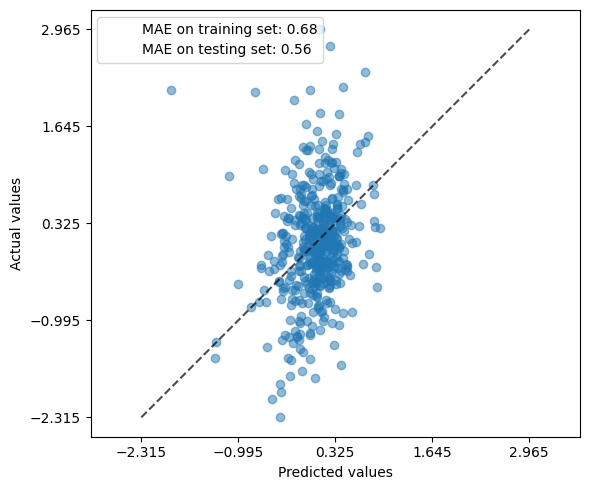

In [75]:
mae_train = mean_absolute_error(y_train, clf.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
scores = {
    "MAE on training set": f"{mae_train:.2f}",
    "MAE on testing set": f"{mae_test:.2f}",
}
_, ax = plt.subplots(figsize=(6, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
#ax.set_title("Ridge model, CV-optimised regularisation parameter")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
#plt.savefig('MAE_plot_daily_all-ind.png',dpi=600)
plt.savefig('MAE_plot_daily_all-ind_no-title.png',dpi=600)

Interpret coefficients

In [76]:
# interpreting coefficients

feature_names = ridge_df.dropna().columns

coefs = pd.DataFrame(
    np.ndarray.flatten(clf.coef_),
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
DXY ret.,0.185604
HSIL,-0.606986
SPY ret.,0.105792
AUDUSD ret.,0.169415
AUDCNY ret.,-0.030788
...,...
HKDAUD ret. lag 20,-0.207137
HKDAUD ret. lag 60,0.092889
HKDAUD ret. lag -5,0.213516
HKDAUD ret. lag -20,-0.036002


### 7.1.1 Individual indicators and different lag periods

In [123]:
coefs[coefs.index.str.contains('DXY ret.')]

,Coefficients
DXY ret.,0.185604
DXY ret. lag 5,0.079628
DXY ret. lag 20,-0.044140
DXY ret. lag 60,0.071833
DXY ret. lag -5,0.065201
DXY ret. lag -20,-0.124185
DXY ret. lag -60,0.031226


In [41]:
def plot_normalised_ridge_coeffs(coefs,exo_var):
    '''
    Given a dataframe (index = name of coeff), first column "Coefficients", plot a barchart.
    '''

    coefs[coefs.index.str.contains(exo_var)].plot.barh(figsize=(9, 7))
    plt.title("Ridge model regularisation-optimised " + '('+str(exo_var)+')')
    plt.xlabel("Normalised coefficient values")
    plt.axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)
    filename = 'ridge_coeff_plot_'+str(exo_var)+'.png'

    plt.savefig(str(filename),dpi=600)

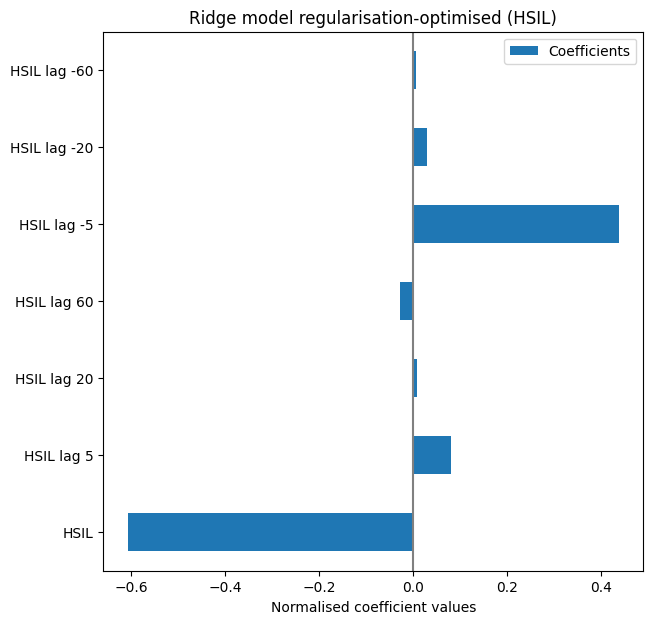

In [139]:
plot_normalised_ridge_coeffs(coefs,'HSIL')

In [140]:
# generate plots of coefficients (do this only once) 

list_of_exo = list(macro_daily_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

for elem in list_of_exo:
    plot_normalised_ridge_coeffs(coefs,elem)
    plt.close()

### 7.1.2 Improved model using only significant coefficients

In [57]:
X = ridge_df.dropna()

In [58]:
# run ridge regression

X = ridge_df.dropna()

# define new dataset using indicators with significant coefficients

X = X[['USDHKD ret.',\
       'AUDCNY ret. lag 5',\
       'AUDUSD ret.',\
       'AUDUSD ret. lag 20',\
       'CNYHKD ret.','DXY ret.',\
       'HKDAUD ret. lag 20',\
       'HKDEUR ret.',\
       'HKDEUR ret. lag 20',\
       'HSIL',\
       'SPY ret.']]

y = macro_daily_df['HK50 ret.'][ridge_df.dropna().index[0]:ridge_df.dropna().index[-1]]

# scale the data
data_scaler_x = StandardScaler()
data_scaler_y = StandardScaler()

# use the below if only one feature
# X = data_scaler_x.fit_transform(X.values.reshape(-1, 1))
X = data_scaler_x.fit_transform(X.values)
y = data_scaler_y.fit_transform(y.values.reshape(-1,1))

# test / train split
X_train, y_train, X_test, y_test = macro_test_train_split(X,y)

# fit ridge regression model
alphas = np.logspace(-10, 10, 21)
clf = RidgeCV(alphas=alphas).fit(X_train,y_train)

# return R^2
clf.score(X_train, y_train) # in-sample performance
clf.score(X_test, y_test) # out-of-sample performance

print(f'R^2 error (train): {np.round(clf.score(X_train, y_train),5)}')
print(f'R^2 error (test): {np.round(clf.score(X_test, y_test),5)}')

# get predicted values (out of sample performance)
y_pred_scaled = clf.predict(X_test)
y_pred = y_pred_scaled#data_scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_abs_pct_error(y_test,y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# alphas
print('Regularisation parameter after CV: '+str(clf.alpha_))
# alphas

R^2 error (train): 0.17125
R^2 error (test): 0.03935
Mean Absolute Error (MAE): 0.56
Mean Squared Error (MSE): 0.54
Mean Absolute Percentage Error (MAPE): 233.81 %
Regularisation parameter after CV: 1.0


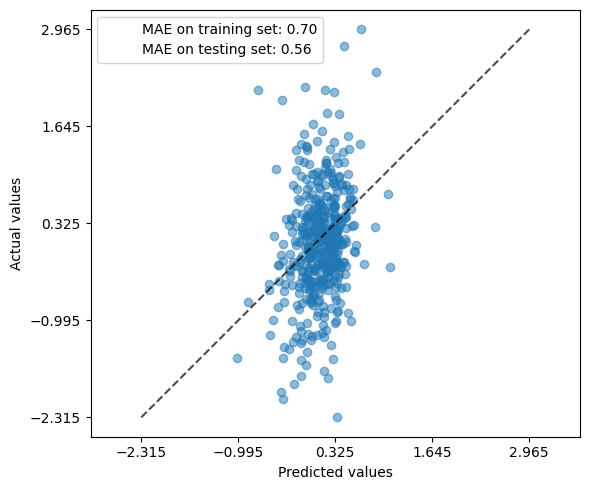

In [71]:
mae_train = mean_absolute_error(y_train, clf.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
scores = {
    "MAE on training set": f"{mae_train:.2f}",
    "MAE on testing set": f"{mae_test:.2f}",
}
_, ax = plt.subplots(figsize=(6, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
#ax.set_title("Ridge model, CV-optimised regularisation parameter")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
#plt.savefig('MAE_plot_daily_v2.png',dpi=600)
plt.savefig('MAE_plot_daily_v2_no-title.png',dpi=600)

In [60]:
# interpreting coefficients
X = ridge_df.dropna()

# define new dataset using indicators with significant coefficients

X = X[['USDHKD ret.',\
       'AUDCNY ret. lag 5',\
       'AUDUSD ret.',\
       'AUDUSD ret. lag 20',\
       'CNYHKD ret.','DXY ret.',\
       'HKDAUD ret. lag 20',\
       'HKDEUR ret.',\
       'HKDEUR ret. lag 20',\
       'HSIL',\
       'SPY ret.']]

feature_names = X.dropna().columns

coefs = pd.DataFrame(
    np.ndarray.flatten(clf.coef_),
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
USDHKD ret.,-0.150650
AUDCNY ret. lag 5,-0.003410
AUDUSD ret.,0.217815
AUDUSD ret. lag 20,-0.594549
CNYHKD ret.,0.158417
DXY ret.,0.177645
HKDAUD ret. lag 20,-0.572235
HKDEUR ret.,-0.037084
HKDEUR ret. lag 20,-0.028453
HSIL,-0.156436


In [54]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

In [61]:
coefs.head()

,Coefficients
USDHKD ret.,-0.150650
AUDCNY ret. lag 5,-0.003410
AUDUSD ret.,0.217815
AUDUSD ret. lag 20,-0.594549
CNYHKD ret.,0.158417


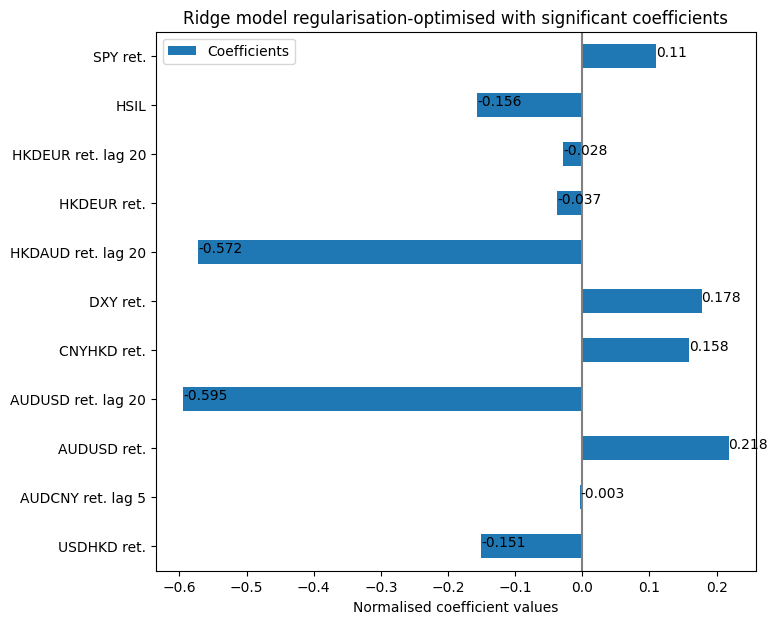

In [67]:
coefs.plot.barh(figsize=(10, 7))
for index, value in enumerate(coefs.Coefficients):
    plt.text(value, index,
             str(round(value,3)))
plt.title("Ridge model regularisation-optimised with significant coefficients")
plt.xlabel("Normalised coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

plt.savefig('ridge_coeffs_daily_v2.png',dpi=600)

## 7.2 Monthly models

In [ ]:
# leading indicator variables and date ranges
#macro_monthly_df_short.shift(1)['2013-04-01':'2022-11-01'].dropna() # 5 days. Dates ['2013-04-01':'2022-10-01']
#macro_monthly_df_short.shift(3)['2013-04-01':'2022-11-01'].dropna() # 20 days. Dates ['2013-04-01':'2022-08-01']
#macro_monthly_df_short.shift(6)['2013-04-01':'2022-11-01'].dropna() # 60 days. Dates ['2013-04-01':'2022-05-01']
# lagging indicator variables and date ranges
#macro_monthly_df_short.shift(-1)['2013-04-01':'2022-11-01'].dropna() # 1 month. Dates ['2013-05-01':'2022-11-01']
#macro_monthly_df_short.shift(-3)['2013-04-01':'2022-11-01'].dropna() # 3 months. Dates ['2013-07-01':'2022-11-01']
#macro_monthly_df_short.shift(-6)['2013-04-01':'2022-11-01'].dropna() # 6 months. Dates ['2013-10-01':'2022-11-01']

In [88]:
# fit a model for everything
ridge_df = macro_monthly_df.copy()
lags = [1,3,6,-1,-3,-6]

for elem in list(macro_monthly_df.columns):
    for lag in lags:
        col_name = str(elem) + ' lag ' + str(lag)
        ridge_df[col_name] = ridge_df[elem].shift(lag)


# drop all columns containing HK50 (the 
ridge_df = ridge_df.loc[:,~ridge_df.columns.str.contains('HK50 ret.')]

X = ridge_df.dropna()
y = macro_monthly_df['HK50 ret.'][ridge_df.dropna().index[0]:ridge_df.dropna().index[-1]]

In [89]:
X.head()

,US10Y,CN10Y,CAIXIN,US_CPI_FRED_all ret.,US_CPI_OECD ret.,CN_CPI_OECD ret.,US_M2 ret.,CN_M2 ret.,EU_M2 ret.,US10Y lag 1,...,CN_M2 ret. lag 6,CN_M2 ret. lag -1,CN_M2 ret. lag -3,CN_M2 ret. lag -6,EU_M2 ret. lag 1,EU_M2 ret. lag 3,EU_M2 ret. lag 6,EU_M2 ret. lag -1,EU_M2 ret. lag -3,EU_M2 ret. lag -6
2018-06-01,0.00,1.64,51.1,0.000901,0.001592,0.000000,0.004364,0.003801,0.007481,0.06,...,0.007781,0.004249,0.004151,0.005888,0.003763,0.001184,0.005592,0.005724,0.002667,0.003669
2018-05-01,0.05,1.85,51.1,0.002255,0.004151,-0.001905,0.003817,0.004249,0.005724,0.00,...,0.007425,0.004747,0.011428,0.008569,0.007481,-0.000052,0.005178,0.005167,-0.000315,0.003808
2018-04-01,0.51,1.85,51.0,0.002601,0.003967,-0.001901,0.001588,0.004747,0.005167,0.05,...,0.007361,0.004151,0.009204,0.008313,0.005724,0.003763,0.002486,0.002667,0.000497,0.001568
2018-03-01,0.41,1.68,51.6,0.000192,0.002258,-0.011332,0.003968,0.004151,0.002667,0.51,...,0.007165,0.011428,0.005888,0.008558,0.005167,0.007481,0.001184,-0.000315,0.003669,0.002987
2018-02-01,0.64,0.96,51.5,0.002689,0.004525,0.012282,0.003023,0.011428,-0.000315,0.41,...,0.007735,0.009204,0.008569,0.006934,0.002667,0.005724,-0.000052,0.000497,0.003808,0.003815


In [90]:
# run ridge regression

X = ridge_df.dropna()
y = macro_monthly_df['HK50 ret.'][ridge_df.dropna().index[0]:ridge_df.dropna().index[-1]]

# scale the data
data_scaler_x = StandardScaler()
data_scaler_y = StandardScaler()

# use the below if only one feature
# X = data_scaler_x.fit_transform(X.values.reshape(-1, 1))
X = data_scaler_x.fit_transform(X.values)
y = data_scaler_y.fit_transform(y.values.reshape(-1,1))

# test / train split
X_train, y_train, X_test, y_test = macro_test_train_split(X,y)

# fit ridge regression model
alphas = np.logspace(-10, 10, 21)
clf = RidgeCV(alphas=alphas).fit(X_train,y_train)

# return R^2
clf.score(X_train, y_train) # in-sample performance
clf.score(X_test, y_test) # out-of-sample performance

print(f'R^2 error (train): {np.round(clf.score(X_train, y_train),5)}')
print(f'R^2 error (test): {np.round(clf.score(X_test, y_test),5)}')

# get predicted values (out of sample performance)
y_pred_scaled = clf.predict(X_test)
y_pred = y_pred_scaled#data_scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Squared Error (MSE)
MSE = mean_squared_error(y_test,y_pred)
print(f'Mean Squared Error (MSE): {np.round(MSE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = mean_abs_pct_error(y_test,y_pred)
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# alphas
print('Regularisation parameter after CV: '+str(clf.alpha_))
# alphas

R^2 error (train): 0.13796
R^2 error (test): -0.16668
Mean Absolute Error (MAE): 0.63
Mean Squared Error (MSE): 0.6
Mean Absolute Percentage Error (MAPE): 226.4 %
Regularisation parameter after CV: 1000.0


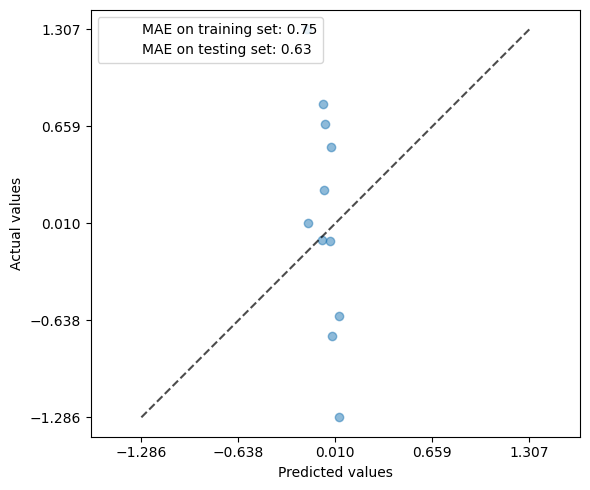

In [92]:
mae_train = mean_absolute_error(y_train, clf.predict(X_train))
mae_test = mean_absolute_error(y_test, y_pred)
scores = {
    "MAE on training set": f"{mae_train:.2f}",
    "MAE on testing set": f"{mae_test:.2f}",
}
_, ax = plt.subplots(figsize=(6, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
#ax.set_title("Ridge model, CV-optimised regularisation parameter")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()
#plt.savefig('MAE_plot_monthly_all-ind.png',dpi=600)
plt.savefig('MAE_plot_monthly_all-ind_no-title.png',dpi=600)

In [93]:
# interpreting coefficients

feature_names = ridge_df.dropna().columns

coefs = pd.DataFrame(
    np.ndarray.flatten(clf.coef_),
    columns=["Coefficients"],
    index=feature_names,
)

coefs

,Coefficients
US10Y,-0.003269
CN10Y,0.006647
CAIXIN,0.004697
US_CPI_FRED_all ret.,0.004974
US_CPI_OECD ret.,0.002480
...,...
EU_M2 ret. lag 3,-0.008869
EU_M2 ret. lag 6,-0.001315
EU_M2 ret. lag -1,0.001473
EU_M2 ret. lag -3,0.000167


### 7.2.1 Individual indicators and different lag periods

In [94]:
# generate plots of coefficients (do this only once) 

list_of_exo = list(macro_monthly_df.keys())
list_of_exo.remove('HK50 ret.')
list_of_exo

for elem in list_of_exo:
    plot_normalised_ridge_coeffs(coefs,elem)
    plt.close()